In [1]:
import pandas as pd

Loading dataset

In [2]:
df_train = pd.read_feather("../../../data/processed/CLTP_train_set.feather")

In [3]:
X_train = df_train.drop(["CLTP"], axis=1)
y_train = df_train["CLTP"]
del df_train

## Training

In [4]:
from sklearn.utils.class_weight import compute_class_weight 

In [5]:
weights = compute_class_weight("balanced", sorted(y_train.unique()), y_train)
comp_weights = { c: weights[c] for c in sorted(y_train.unique()) }
comp_weights

{0: 0.16605439075282444,
 1: 4.843155260581003,
 2: 5.353106991331788,
 3: 5.71981619876849,
 4: 6.868128544890112,
 5: 7.2886583420934565,
 6: 7.876366004190023}

In [6]:
manual_weights = {
     0: 1,
     4: 20,
     2: 15,
     3: 10,
     6: 5,
     1: 15,
     5: 20}

Dummify 

In [7]:
X_train = X_train.drop(["DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window"], axis=1)

In [8]:
X_train = pd.get_dummies(X_train)

In [9]:
X_train = X_train.fillna(-999)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [11]:
y_train.unique()

array([0, 4, 2, 3, 6, 1, 5], dtype=int64)

In [12]:
rf = RandomForestClassifier(n_estimators=15, n_jobs=-1, class_weight='balanced')
classif = OneVsRestClassifier(rf)
classif.fit(X_train, y_train)  

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=15, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          n_jobs=None)

Dump training columns

In [13]:
cols = list(X_train.columns)

In [14]:
import pickle
with open('../../../src/models/Training columns - CLTP - one vs. rest - dummies.md', 'wb') as file:
    pickle.dump(cols, file, pickle.HIGHEST_PROTOCOL)

### Feature importance

In [15]:
fi = pd.DataFrame(classif.feature_importances_,index=X_train.columns, columns=['importance']
                                   ).sort_values('importance', ascending=False)
fi.iloc[0:20].plot.bar()

AttributeError: 'OneVsRestClassifier' object has no attribute 'feature_importances_'

### Validation Dataset

In [16]:
df_val = pd.read_feather("../../../data/processed/CLTP_validation_set.feather")

In [17]:
X_val = df_val.drop(["CLTP"], axis=1)
y_val = df_val["CLTP"]
del df_val

In [18]:
X_val = X_val.drop(["DATECO_RAZON_SOCIAL_EMPLEADOR","FECHA_NACIMIENTO","time_window"], axis=1)
X_val = pd.get_dummies(X_val)
X_val = X_val.fillna(-999)

In [19]:
for col in [col for col in X_train.columns if col not in X_val.columns]:
    X_val[col] = -999

In [20]:
X_val = X_val.drop([col for col in X_val.columns if col not in X_train.columns], axis=1)

In [21]:
y_val.value_counts().plot.bar()

### Model metrics

In [22]:
from sklearn.metrics import roc_auc_score,confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, roc_auc_score

In [23]:
predictions = classif.predict(X_val)
print('Confusion Matrix')
print(confusion_matrix(y_val, predictions))
print()
print('Metrics')
print(f'Accuracy: {accuracy_score(y_val, predictions)}')
print(f'F1_score: {f1_score(y_val, predictions, average=None)} ')

Confusion Matrix
[[632236    323   1532   2453    234      1      1]
 [    16  17437     15      0      0      0      0]
 [   215      3  17730      2      1      0      0]
 [  7932      1      4   7626    113      1      0]
 [ 11703     28     80    502    733      2      0]
 [ 13345     20    112    112     11      2     26]
 [ 13519     15     66     91      8      0     24]]

Metrics
Accuracy: 0.9279296968864783
F1_score: [9.61030472e-01 9.88071965e-01 9.45852227e-01 5.76351888e-01
 1.03618886e-01 2.93384187e-04 3.48482648e-03] 


In [24]:
import seaborn as sns

In [25]:
cmap = sns.color_palette("coolwarm", 7)

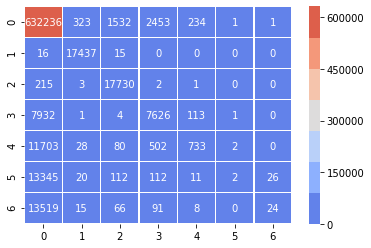

In [26]:
sns.heatmap(confusion_matrix(y_val, predictions), annot=True, fmt="d", linewidths=.5, cmap=cmap) 

In [27]:
pd.crosstab(y_val, predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,6,All
True,,,,,,,,
0,632236,323,1532,2453,234,1,1,636780
1,16,17437,15,0,0,0,0,17468
2,215,3,17730,2,1,0,0,17951
3,7932,1,4,7626,113,1,0,15677
4,11703,28,80,502,733,2,0,13048
5,13345,20,112,112,11,2,26,13628
6,13519,15,66,91,8,0,24,13723
All,678966,17827,19539,10786,1100,6,51,728275
